# Теперь давай ваще что-то клевое

Загрузить датасет `tiny-imagenet-200.zip` можно по [ссылке](https://drive.google.com/drive/folders/1yYkCePVxPGjSLZS4IxTDFzKxzor_kjMT?usp=sharing).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn
from torchvision import transforms
from time import time
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import time
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.checkpoint import checkpoint_sequential
from IPython.display import clear_output
%matplotlib inline

## Данные

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ml2021/tiny-imagenet-200.zip

In [13]:
class ValDataset(Dataset):
    def __init__(self, csv_file, root, transform=None):
        self.info = pd.read_csv(csv_file, sep='\t', header=None)
        self.root = root
        self.transform = transform
        classes = pd.read_csv('tiny-imagenet-200/wnids.txt', sep='\t', header=None).sort_values(0).reset_index(drop=True)
        self.classes_dict = {classes[0][i]:i for i in range(200)} # class id to class

    def __len__(self):
        return len(self.info)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.info.iloc[idx, 0])
        image = np.asarray(Image.open(img_name).convert('RGB'))
        target = self.classes_dict[self.info.iloc[idx, 1]]

        if self.transform:
            image = self.transform(image)

        return image, target


In [14]:
transform_train = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform_train)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])
test_dataset  = ValDataset(csv_file='tiny-imagenet-200/val/val_annotations.txt',
                          root='tiny-imagenet-200/val/images',   
                          transform=transform_test)

In [15]:
batch_size = 64
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val'  : DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=2),
    'test' : DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=2) 
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Modelling

In [16]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Accuracy(nn.Module):
    def __init__(self):
        super(Accuracy, self).__init__()

    def forward(self, outputs, targets):
        return torch.mean((outputs == targets).double())

In [17]:
def block(cin, cout, kernel_size=(3,3), padding=(1,1), stride=(1,1), pool_size=(2,2)):
    return nn.Sequential(
        nn.Conv2d(in_channels=cin, 
                  out_channels=cout, 
                  kernel_size=kernel_size, 
                  padding=padding, 
                  stride=stride),
        nn.BatchNorm2d(num_features=cout),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=pool_size)
    )

def get_model(cin=3, cout=200, base=64, drop=0.2):
    return torch.nn.Sequential(
        block(cin=cin, 
              cout=base),
        block(cin=base, 
              cout=base*2),
        nn.Dropout(0.2),
        block(cin=base*2, 
              cout=base*4),
        block(cin=base*4, 
              cout=base*8),
        nn.Flatten(),
        nn.Dropout(drop),
        nn.Linear(in_features=base*8*4*4, 
                  out_features=base*16),
        nn.ReLU(),
        nn.Dropout(drop),
        nn.Linear(in_features=base*16, 
                  out_features=cout)
    )

## Training

In [23]:
def train_epoch(model, dataloader, criterion, metric, device, optimizer):
    total_loss = 0
    total_acc  = 0
    n = len(dataloader)    

    model.train(True)
    for i_batch, (X_batch, y_batch) in enumerate(dataloader):
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        X_batch.requires_grad = True
        out = model(X_batch)

        loss = criterion(out, y_batch)
        loss.backward()
        total_loss += loss.item()

        _, y_preds = torch.max(out, 1)
        total_acc += metric(y_preds, y_batch).item()

        optimizer.step()
        optimizer.zero_grad()


    av_loss = total_loss / n
    av_acc  = total_acc  / n

    return av_loss, av_acc

In [19]:
@torch.no_grad()
def eval_model(model, dataloader, criterion, metric, device):
    total_acc = 0
    n = len(dataloader)  
    
    model.eval()
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
 
        out = model(X_batch)
        _, y_preds = torch.max(out, 1)
        total_acc += metric(y_preds, y_batch).item()
 
    av_acc = total_acc / n
 
    return av_acc

In [ ]:
@torch.no_grad()
def get_result(model, dataloader, device):
    n = len(dataloader)  
    answer = torch.empty(0)

    model.eval()
    for X_batch, _ in dataloader:
        X_batch = X_batch.to(device)
 
        out = model(X_batch)

        answer = torch.cat([answer, out.argmax(-1).to('cpu')])

    return answer

In [20]:
def draw_accuracy(log):
    clear_output(True)
    np_log = np.array(log)
    plt.title("Accuracy")
    plt.plot(np_log[:, 0], label='train')
    plt.plot(np_log[:, 1], label='val')
    plt.grid()
    plt.legend()
    plt.show()


In [24]:
def train_model(model, dataloaders, optimizer,
                criterion=nn.CrossEntropyLoss(), 
                metric=Accuracy(), 
                device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu'), 
                epochs=50):
    
    model = model.to(device)
    log_acc = []
    for epoch in range(epochs):
        start_time = time.time()
        
        loss, train_acc = train_epoch(model, dataloaders['train'], criterion, metric, device, optimizer)   
        
        val_acc  =         eval_model(model, dataloaders['val'],   criterion, metric, device)

        log_acc.append((train_acc, val_acc))
        
        draw_accuracy(log_acc)
 
        print("Epoch [{}/{}] Time: {:.2f}s; TrainLoss: {:.4f}; TrainAccuracy: {:.4f}; ValAccuracy: {:.4f}".format(
              epoch + 1, epochs, time.time() - start_time, loss, train_acc, val_acc))    
    
    return model, val_acc

# Обучение модели

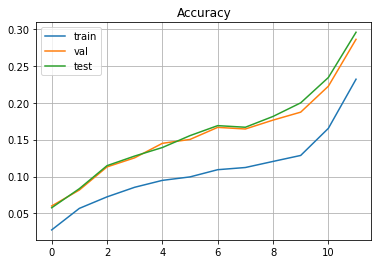

Epoch [12/50] Time: 68.77s; TrainLoss: 3.3974; TrainAccuracy: 0.2319; ValAccuracy: 0.2859, TestAccuracy: 0.2955


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
torch.cuda.empty_cahce()
model = get_model()

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model, val_accuracy, test_accuracy = train_model(model=model, 
                                                         dataloaders=dataloaders, 
                                                         optimizer=optimizer, 
                                                         epochs=50)

# Получение результата

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
test_result = get_result(model, dataloader['test'], device)

-----------------------------------
## Другие Эксперименты

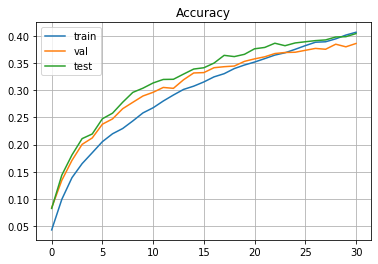

Epoch [31/50] Time: 74.80s; TrainLoss: 2.4074; TrainAccuracy: 0.4064; ValAccuracy: 0.3858, TestAccuracy: 0.4040
Peak memory usage by Pytorch tensors: 660.85 Mb
Full_time: 2356.09s


In [ ]:
model = get_model()

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model, val_accuracy, test_accuracy = train_model(model=model, 
                                                         dataloaders=dataloaders, 
                                                         optimizer=optimizer, 
                                                         epochs=50,
                                                         max_acc=0.4,
                                                         eff_batch_size=128)